In [67]:
import numpy as np

def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open('180/model.txt', encoding='utf-8') as f:
        for line in f:
            word_, *vector = line.split()
            word = word_.split('_')[0]
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [58]:
with open('180/model.txt', encoding='utf-8') as f:
    i = 0
    for line in f:
        word, *vector = line.split()
        i = i + 1 
    print(i)

189194


In [41]:
import pymorphy2
import nltk
import string
from nltk.corpus import stopwords


morph = pymorphy2.MorphAnalyzer()

stop_words = stopwords.words('russian')
stop_words.extend(['«', '»', '–', '...', '“', '”', '—', '!',
                   '@', '№', ':', ',', '.', '?', ':', '(', ')'])
stop_words = set(stop_words)

def normalize_review(review):
    """

    :param review:
    :param morph:
    :return:
    """

    tokens = nltk.word_tokenize(review)
    normalized_tokens = []
    # normalized_review = ''
    for token in tokens:
        token = morph.parse(token)[0].normal_form
        if token not in stop_words and token not in string.punctuation:
            normalized_tokens.append(token.lower())

    return " ".join(normalized_tokens)

In [51]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

train_texts = []
with open('ALL_reviews.txt', encoding='utf-8') as f:
    for line in f:
        train_texts.append(normalize_review(line))

test_texts = []
with open('all_my_reviews.txt', encoding='utf-8') as f:
    for line in f:
        test_texts.append(normalize_review(line))

        
tokenizer.fit_on_texts(train_texts)
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

In [52]:
print(len(X_train))
print(len(X_test))
print(tokenizer.word_index.items())

610
90
dict_items([('фильм', 1), ('это', 2), ('весь', 3), ('который', 4), ('свой', 5), ('человек', 6), ('то', 7), ('мочь', 8), ('самый', 9), ('очень', 10), ('герой', 11), ('просто', 12), ('хороший', 13), ('ещё', 14), ('история', 15), ('время', 16), ('жизнь', 17), ('главный', 18), ('10', 19), ('сюжет', 20), ('персонаж', 21), ('картина', 22), ('смотреть', 23), ('сказать', 24), ('большой', 25), ('год', 26), ('зритель', 27), ('каждый', 28), ('кино', 29), ('мир', 30), ('сцена', 31), ('стать', 32), ('актёр', 33), ('момент', 34), ('какой', 35), ('роль', 36), ('мультфильм', 37), ('режиссёр', 38), ('просмотр', 39), ('хотя', 40), ('говорить', 41), ('часть', 42), ('сделать', 43), ('тарантино', 44), ('работа', 45), ('посмотреть', 46), ('ничто', 47), ('новый', 48), ('хотеть', 49), ('конец', 50), ('имя', 51), ('нолана', 52), ('лишь', 53), ('видеть', 54), ('игра', 55), ('именно', 56), ('почему', 57), ('друг', 58), ('что', 59), ('вообще', 60), ('наш', 61), ('понравиться', 62), ('стоить', 63), ('образ'

In [85]:
max_len = 500

from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(X_train, maxlen=max_len)
x_test = pad_sequences(X_test, maxlen=max_len)

In [86]:
embedding_dim = 128
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dim)

In [87]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements / vocab_size

0.7830840971217238

In [95]:
max_words = 18657
num_classes = 3

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPool1D


model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len, weights=[embedding_matrix], trainable=True))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          2388096   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 498, 128)          49280     
_________________________________________________________________
activation_8 (Activation)    (None, 498, 128)          0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_9 (Activation)    (None, 3)                 0         
Total params: 2,437,763
Trainable params: 2,437,763
Non-trainable params: 0
____________________________________________

In [89]:
print(model.metrics_names)


['loss', 'accuracy']


In [90]:
import pandas
excel_file = pandas.read_excel('Отзывы кино.xlsx', 0)

# Оценки для отзывов
Y_train = []

for i, row in excel_file.iterrows():
    if (row['title'] != 'Криминальное чтиво' and
        row['title'] != 'Маленькая Мисс Счастье' and
        row['title'] != 'Амели'):
        Y_train.append(row['label'])
        
Y_test = []

for i, row in excel_file.iterrows():
    if (row['title'] == 'Криминальное чтиво' or
        row['title'] == 'Маленькая Мисс Счастье' or
        row['title'] == 'Амели'):
        Y_test.append(row['label'])
        
print(len(Y_train))
print(len(Y_test))

610
90


In [91]:
import keras
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(610, 500)
(90, 500)
(610, 3)
(90, 3)


In [117]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


Train on 610 samples, validate on 90 samples
Epoch 1/10
610/610 [==============================] - 2s 3ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.6732 - val_accuracy: 0.4222
Epoch 2/10
610/610 [==============================] - 2s 3ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 1.5604 - val_accuracy: 0.4000
Epoch 3/10
610/610 [==============================] - 2s 3ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.5433 - val_accuracy: 0.4000
Epoch 4/10
610/610 [==============================] - 2s 3ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 1.7638 - val_accuracy: 0.3889
Epoch 5/10
610/610 [==============================] - 2s 4ms/step - loss: 0.0117 - accuracy: 0.9984 - val_loss: 1.6158 - val_accuracy: 0.4000
Epoch 6/10
610/610 [==============================] - 2s 4ms/step - loss: 0.0097 - accuracy: 0.9984 - val_loss: 1.7113 - val_accuracy: 0.4111
Epoch 7/10
610/610 [==============================] - 2s 3ms/step - loss: 0.0089 - accuracy: 0.9984 - v

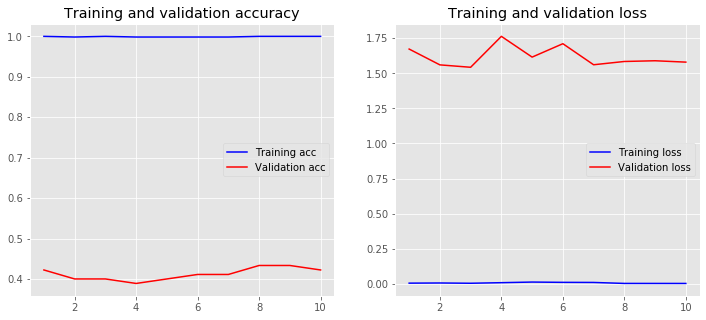

In [118]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

predictions = model.predict(x_test)

act_classes = [1]*30 + [-1]*30 + [0]*30
import numpy as np

labels = {
    0: 0,
    1: 1,
    2: -1
}

pred_classes = [labels[np.argmax(x)] for x in predictions]

print("CNN 10 Accuracy Score -> ",accuracy_score(pred_classes, act_classes)*100)
print(precision_recall_fscore_support(act_classes, pred_classes, average='weighted'))



Train on 610 samples, validate on 90 samples
Epoch 1/20
610/610 [==============================] - 2s 3ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5811 - val_accuracy: 0.4222
Epoch 2/20
610/610 [==============================] - 2s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.5885 - val_accuracy: 0.4222
Epoch 3/20
610/610 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.5880 - val_accuracy: 0.4333
Epoch 4/20
610/610 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.5877 - val_accuracy: 0.4333
Epoch 5/20
610/610 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.5918 - val_accuracy: 0.4333
Epoch 6/20
610/610 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.5935 - val_accuracy: 0.4333
Epoch 7/20
610/610 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - v

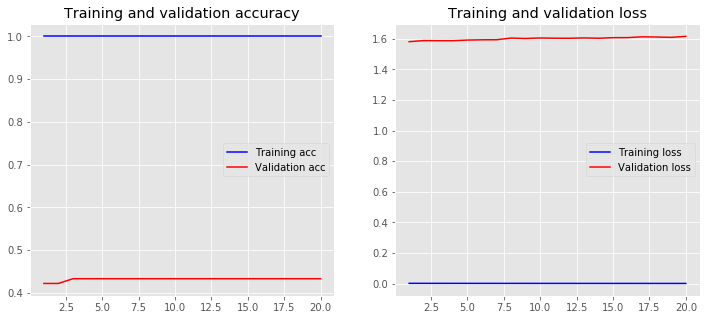

In [119]:
# 20 epochs

history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

predictions = model.predict(x_test)

pred_classes = [labels[np.argmax(x)] for x in predictions]

print("CNN 20 Accuracy Score -> ",accuracy_score(pred_classes, act_classes)*100)
print(precision_recall_fscore_support(act_classes, pred_classes, average='weighted'))



Train on 610 samples, validate on 90 samples
Epoch 1/30
610/610 [==============================] - 2s 3ms/step - loss: 6.6337e-04 - accuracy: 1.0000 - val_loss: 1.6551 - val_accuracy: 0.4333
Epoch 2/30
610/610 [==============================] - 2s 3ms/step - loss: 6.5491e-04 - accuracy: 1.0000 - val_loss: 1.6604 - val_accuracy: 0.4333
Epoch 3/30
610/610 [==============================] - 2s 3ms/step - loss: 6.3823e-04 - accuracy: 1.0000 - val_loss: 1.6598 - val_accuracy: 0.4333
Epoch 4/30
610/610 [==============================] - 2s 3ms/step - loss: 6.2746e-04 - accuracy: 1.0000 - val_loss: 1.6572 - val_accuracy: 0.4333
Epoch 5/30
610/610 [==============================] - 2s 3ms/step - loss: 6.2100e-04 - accuracy: 1.0000 - val_loss: 1.6563 - val_accuracy: 0.4333
Epoch 6/30
610/610 [==============================] - 2s 3ms/step - loss: 6.1234e-04 - accuracy: 1.0000 - val_loss: 1.6612 - val_accuracy: 0.4333
Epoch 7/30
610/610 [==============================] - 2s 3ms/step - loss: 5.944

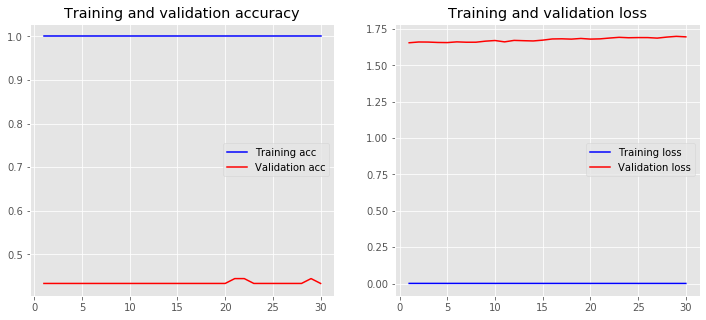

In [122]:
# 30 epochs

history = model.fit(x_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

predictions = model.predict(x_test)

pred_classes = [labels[np.argmax(x)] for x in predictions]

print("CNN 30 Accuracy Score -> ",accuracy_score(pred_classes, act_classes)*100)
print(precision_recall_fscore_support(act_classes, pred_classes, average='weighted'))
